In [6]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
from statsmodels.tsa.arima.model import ARIMA

# Подготовка данных
file_path = 'Ad revenue.xlsx'
df = pd.read_excel(file_path)

# Удаление пропусков 
df.replace(['', 'None', 'N/A', 'n/a', 'Undefined'], pd.NA, inplace=True)
df_clean = df.dropna()

# Нахождение межквартильного размаха
Q1 = df_clean['event_revenue'].quantile(0.25)
Q3 = df_clean['event_revenue'].quantile(0.75)

IQR = Q3 - Q1

# Верхняя и нижняя граница 
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Удаление выбросов
df_no_outliers = df_clean[(df_clean['event_revenue'] >= lower_bound) & (df_clean['event_revenue'] <= upper_bound)]


# Преобразуем колонки с датами в формат datetime для удобства работы
df_no_outliers['event_date'] = pd.to_datetime(df_no_outliers['event_date'])

C:\Temp\ipykernel_592\1674613680.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['event_date'] = pd.to_datetime(df_no_outliers['event_date'])


In [7]:
# Группируем 
daily_revenue = df_no_outliers.groupby('event_date')['event_revenue'].sum().cumsum()

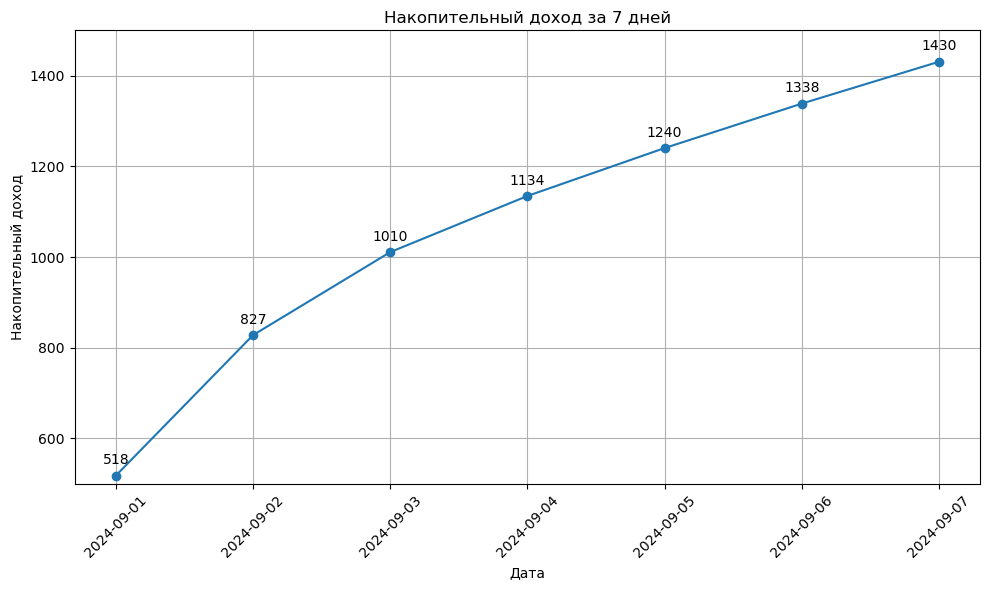

In [8]:
# Построим график накопительного дохода
plt.figure(figsize=(10, 6))
plt.plot(daily_revenue, label='Накопительный доход', marker='o')

for i, value in enumerate(daily_revenue):
    plt.text(daily_revenue.index[i], round(value, 2) + 25, f'{int(value)}', ha='center')

plt.grid()
plt.title('Накопительный доход за 7 дней')
plt.xlabel('Дата')
plt.ylabel('Накопительный доход')
plt.xticks(rotation=45)
plt.ylim(500,1500)
plt.tight_layout()


plt.savefig('plot1.png', dpi=300)
plt.show()

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


MAE: 0.96, RMSE: 0.96


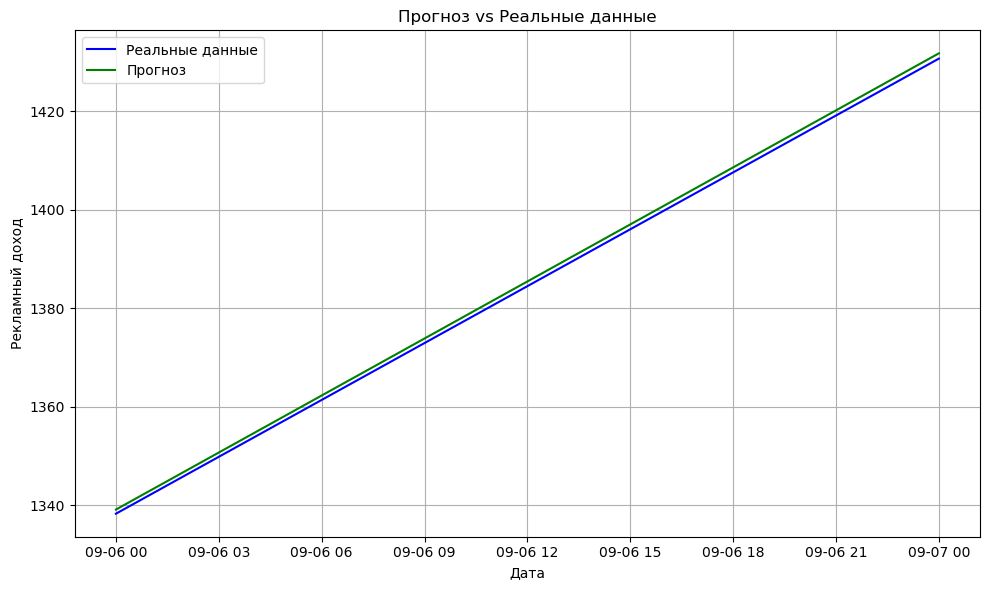

C:\ProgramData\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


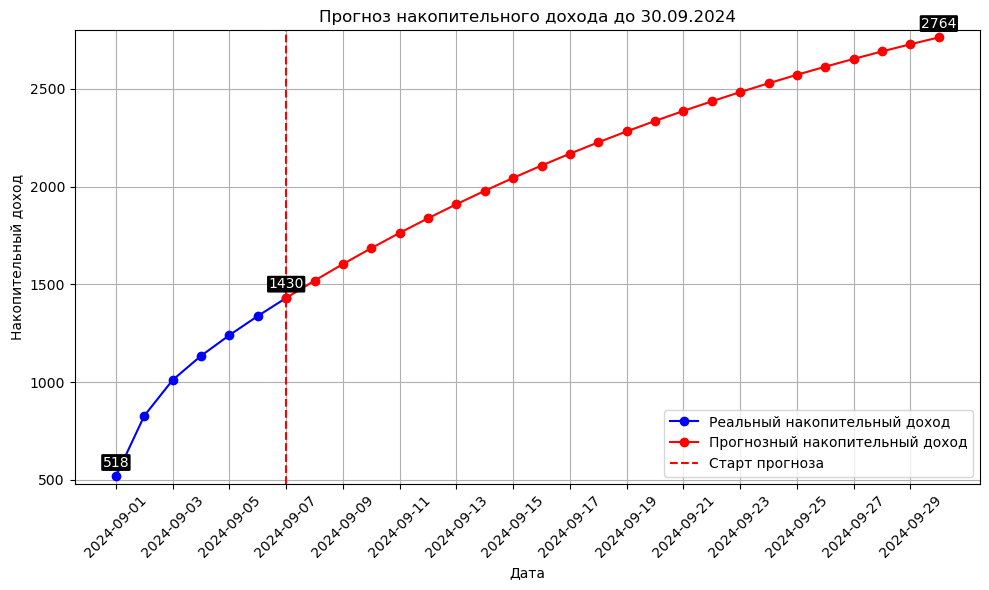

In [9]:
# Разделение данных на обучающие и тестовые выборки
train = daily_revenue[:-2]  # Используем первые 5 дней для обучения
test = daily_revenue[-2:]   # Последние 2 дня для тестирования

model = ARIMA(train, order=(1,1,0), freq='D')  # Задаем модель ARIMA
fit_model = model.fit()

# Прогноз на тестовую выборку
forecast = fit_model.forecast(len(test))

# Оценка точности прогноза
mae = mean_absolute_error(test, forecast)    
rmse = np.sqrt(mean_squared_error(test, forecast))  
print(f'MAE: {round(mae, 2)}, RMSE: {round(rmse, 2)}')

# Визуализация фактических данных и прогноза на тесте
plt.figure(figsize=(10, 6))
plt.plot(test.index, test, label='Реальные данные', color='blue')
plt.plot(test.index, forecast, label='Прогноз', color='green')
plt.title('Прогноз vs Реальные данные')
plt.xlabel('Дата')
plt.ylabel('Рекламный доход')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig('plot2.png')
plt.show()

# Прогноз до 30.09.2024 на основе всей выборки
full_model = ARIMA(daily_revenue, order=(1,1,0), freq='D')
full_fit_model = full_model.fit()

# Прогноз на будущее
forecast_days = (pd.to_datetime('2024-09-30') - daily_revenue.index[-1]).days
full_forecast = full_fit_model.forecast(forecast_days)

# Объединение фактических данных и прогноза
full_series = pd.concat([daily_revenue, full_forecast])

# Визуализация полного прогноза и остальных графиков
plt.figure(figsize=(10, 6))
plt.plot(full_series[:7], label='Реальный накопительный доход', color='blue', marker='o', zorder=2.0)
plt.plot(full_series[6:], label='Прогнозный накопительный доход', color='red', marker='o', zorder=2.5)
plt.axvline(x=daily_revenue.index[-1], linestyle='--', color='red', label='Старт прогноза')

for i, value in enumerate(full_series):
    if int(value) in (518, 1430, 2764):
        plt.text(full_series.index[i], round(value, 2) + 50, f'{int(value)}', color='white', ha='center',
                    bbox=dict(facecolor='black', alpha=1, boxstyle='round,pad=0.05'))

plt.title('Прогноз накопительного дохода до 30.09.2024')
plt.xlabel('Дата')
plt.ylabel('Накопительный доход')
plt.legend()
plt.grid(True)
plt.xticks(full_series.index[::2], rotation=45)
plt.ylim(480,2800)
plt.tight_layout()
plt.savefig('plot3.png')
plt.show()

In [10]:
# Найдём во сколько раз накопительный доход к 30-му дню будет больше дохода в день установки игры
round((full_series.iloc[-1])/(full_series.iloc[0]), 1)

5.3